In [38]:
import wfdb
import pandas as pd
import numpy as np
import heartpy as hp
import matplotlib.pyplot as plt

In [40]:
# Define the record name (without extension)
record_name = "rec_1"  # Change this to your file

# Load the ECG signal from the .dat file
record = wfdb.rdrecord(record_name)

# Extract raw and filtered ECG signals
raw_signal = record.p_signal[:, 0]  # Signal 0: Raw ECG
filtered_signal = record.p_signal[:, 1] if record.n_sig > 1 else None  # Signal 1 (if available)

# Create a DataFrame for the ECG signal
df_ecg = pd.DataFrame({
    "Time (ms)": [i * 2 for i in range(len(raw_signal))],  # 500 Hz → 2ms per sample
    "Raw ECG": raw_signal
})

if filtered_signal is not None:
    df_ecg["Filtered ECG"] = filtered_signal

# Display first few rows
df_ecg.head()


,Time (ms),Raw ECG,Filtered ECG
0,0,-0.085,-0.115
1,2,-0.080,-0.115
2,4,-0.070,-0.120
3,6,-0.075,-0.120
4,8,-0.095,-0.120


In [42]:
# Load annotations
annotation = wfdb.rdann(record_name, "atr")

# Create DataFrame for annotations
df_annotations = pd.DataFrame({
    "Time (ms)": annotation.sample * 2,  # Convert sample index to ms
    "Annotation Type": annotation.symbol  # Beat types (e.g., 'N' = normal, 'V' = ventricular)
})

# Display first few rows
df_annotations.head()


,Time (ms),Annotation Type
0,704,N
1,938,t
2,1454,N
3,1678,t
4,2270,N


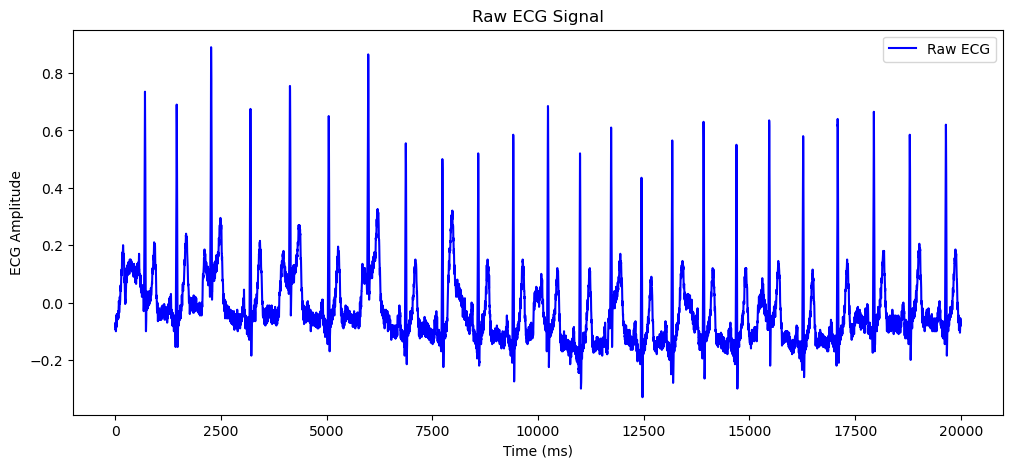

In [44]:
plt.figure(figsize=(12, 5))
plt.plot(df_ecg["Time (ms)"], df_ecg["Raw ECG"], label="Raw ECG", color="blue")
plt.xlabel("Time (ms)")
plt.ylabel("ECG Amplitude")
plt.title("Raw ECG Signal")
plt.legend()
plt.show()


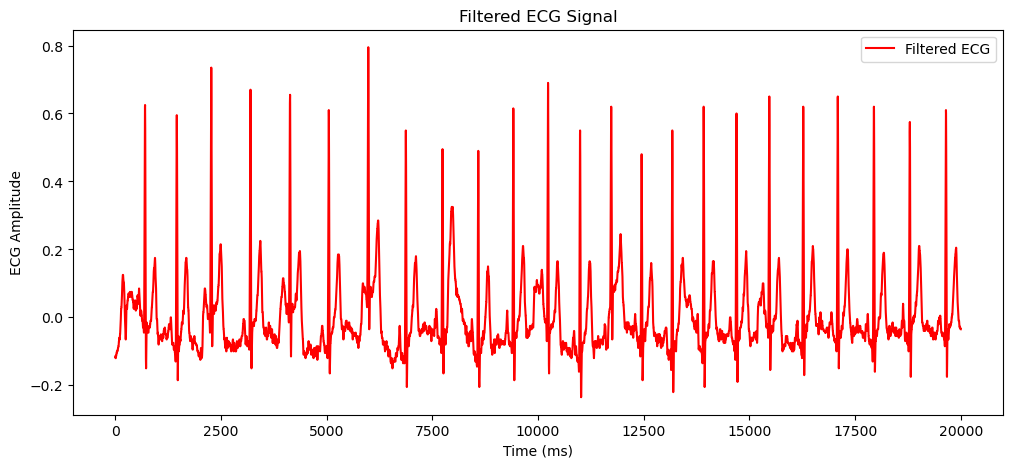

In [45]:
if "Filtered ECG" in df_ecg.columns:
    plt.figure(figsize=(12, 5))
    plt.plot(df_ecg["Time (ms)"], df_ecg["Filtered ECG"], label="Filtered ECG", color="red")
    plt.xlabel("Time (ms)")
    plt.ylabel("ECG Amplitude")
    plt.title("Filtered ECG Signal")
    plt.legend()
    plt.show()


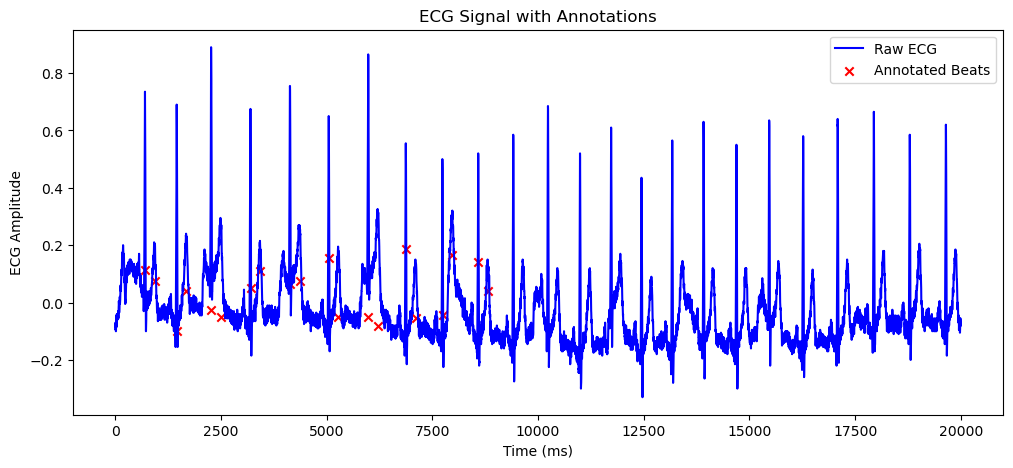

In [48]:
plt.figure(figsize=(12, 5))

# Plot Raw ECG
plt.plot(df_ecg["Time (ms)"], df_ecg["Raw ECG"], label="Raw ECG", color="blue")

# Overlay Beat Annotations
plt.scatter(df_annotations["Time (ms)"], 
            [df_ecg["Raw ECG"].iloc[i//2] for i in annotation.sample], 
            color="red", label="Annotated Beats", marker="x")

plt.xlabel("Time (ms)")
plt.ylabel("ECG Amplitude")
plt.title("ECG Signal with Annotations")
plt.legend()
plt.show()


In [50]:
annotation = wfdb.rdann(record_name, "atr")

# Convert annotations to a DataFrame
df_annotations = pd.DataFrame({
    "Time (sample)": annotation.sample,
    "Time (ms)": annotation.sample * 2,  # Convert samples to milliseconds (500 Hz → 2ms per sample)
    "Annotation Type": annotation.symbol
})

# Get one instance of each unique annotation type
unique_annotations = df_annotations.groupby("Annotation Type").first().reset_index()

# Print the results
print(unique_annotations)

  Annotation Type  Time (sample)  Time (ms)
0               N            352        704
1               t            469        938


In [52]:
fs = 500  

# Extract raw ECG signal from the final DataFrame
ecg_signal = df_ecg["Filtered ECG"].values  

# Detect peaks (R-peaks)
wd, m = hp.process(ecg_signal, sample_rate=fs)

# Extract heart rate (BPM)
heart_rate = m["bpm"]
rr_intervals = np.diff(wd["peaklist"]) * (1000 / fs)  # Convert to milliseconds

# Compute statistical features
mean_rr = np.mean(rr_intervals)
std_rr = np.std(rr_intervals)
median_rr = np.median(rr_intervals)

# Compute signal energy
energy = np.sum(ecg_signal**2)

# Compute signal entropy
entropy = -np.sum(ecg_signal * np.log(np.abs(ecg_signal) + 1e-10))  # Small value to avoid log(0)

# Create a summary dictionary
ecg_features = {
    "Heart Rate (BPM)": heart_rate,
    "Mean RR Interval (ms)": mean_rr,
    "Median RR Interval (ms)": median_rr,
    "RR Interval Std Dev (ms)": std_rr,
    "Signal Energy": energy,
    "Signal Entropy": entropy
}

# Display extracted features
for key, value in ecg_features.items():
    print(f"{key}: {value:.2f}")

Heart Rate (BPM): 72.85
Mean RR Interval (ms): 823.65
Median RR Interval (ms): 822.00
RR Interval Std Dev (ms): 67.07
Signal Energy: 135.56
Signal Entropy: -369.09
